In [8]:
import inspect
import os
import sys

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

#from evaporationLib import *

import numpy as np
import matplotlib.pyplot as plt  # Gives access to basic plotting functions
import matplotlib.gridspec as gridspec  # GRIDSPEC !
from natsort import natsorted
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False
})


concentration_matrix: (1923, 2000)
(1923, 2000)
The overall diffusive flux along pixel_y for 0 =3 is  8.318736211428717e-08
The overall diffusive flux along pixel_y for 0 =6 is  2.0870322530007906e-07
The overall diffusive flux along pixel_y for 0 =9 is  3.3477081389449047e-07
The overall diffusive flux along pixel_y for 0 =12 is  8.850520163705664e-06
The overall diffusive flux along pixel_y for 0 =15 is  9.057747012503595e-06
The overall diffusive flux along pixel_y for 0 =18 is  9.379253324212708e-06
The overall diffusive flux along pixel_y for 0 =21 is  9.7944483640504e-06
The overall diffusive flux along pixel_y for 0 =24 is  1.0272662026729148e-05
The overall diffusive flux along pixel_y for 0 =27 is  1.0744257175661505e-05
The overall diffusive flux along pixel_y for 0 =30 is  1.1292867880507484e-05
The overall diffusive flux along pixel_y for 0 =33 is  1.1783130548113439e-05
The overall diffusive flux along pixel_y for 0 =36 is  1.2245304510709134e-05
The overall diffusive flux

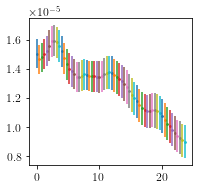

In [9]:
import matplotlib.ticker as ticker
from matplotlib import cm
cmap = cm.viridis_r
import pandas as pd

pixel_size = 5.5E-3
#folder_path = [name for name in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), name))]
folder_path_exp = ['concentration_results_0']
paths_matrices = natsorted(os.listdir(folder_path_exp[0]))
time_values = [int(name.split('_')[-1].replace('.npy', '')) for name in paths_matrices]

# Start by creating the figure
width = 6.0
ratio = 0.35
ratio = 0.4
fig = plt.figure(1, figsize=(width, width * ratio))

# Now, create the gridspec structure, as required
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 0.25, 1])

# 1 rows, 5 columns, each with the required size ratios.
# Also make sure the margins and spacing are apropriate

gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.05, hspace=0.03)

# Note: I set the margins to make it look good on my screen ...
# BUT: this is irrelevant for the saved image, if using bbox_inches='tight'in savefig !

# First, the scatter plot
# Use the gridspec magic to place it
# --------------------------------------------------------
#ax1 = plt.subplot(gs[0, 0]) # place it where it should be.
ax2 = plt.subplot(gs[0, 3])  # place it where it should be.

substrate_position = 106
parameterspath = 'Parameters_0.txt'


def get_mask():
    mask = np.load('ref_mask.npy')
    border_size = 24
    mask = mask[border_size:-border_size, border_size:-border_size]
    return mask

mask = get_mask()

mean_fluxes = []
error_of_mean = []
time_for_xAxis = []

for idx, path in enumerate(paths_matrices):

    temp = np.load(os.path.join(os.getcwd(), folder_path_exp[0], path))
    concentration_matrix = temp
    nan_rows = np.isnan(concentration_matrix).all(axis=1)
    concentration_matrix = concentration_matrix[~nan_rows]
    #print(filtered_arr)
    # Iterate over the rows and copy values from the row before NaN row
    for i in range(1, concentration_matrix.shape[0]):
        if np.isnan(concentration_matrix[i]).any():
            concentration_matrix[i] = concentration_matrix[i-1]
    print("concentration_matrix: " + str(concentration_matrix.shape))

    concentration_matrix = np.flipud(concentration_matrix)
    #masked_conc = np.ma.masked_where(np.flipud(mask) == 0, concentration_matrix)
    masked_conc = concentration_matrix
    print (masked_conc.shape)
    grad_y, grad_x = np.gradient(masked_conc, 5.5E-6,5.5E-06)
    grad_y = grad_y * (-1) * 1.32E-5
    grad_x = grad_x * (-1) * 1.32E-5
    horizontal_start = 818
    horizontal_end = 1364
    list_of_fluxes = []
    integral_lines = np.zeros_like(masked_conc)
    for pixels_above_edge in np.linspace(0.02E-3 / 5.5E-6, 1E-3 / 5.5E-6, 60, dtype=int):

        vertical_row =  pixels_above_edge #substrate_position +

        flux1 = np.trapz(grad_y[vertical_row, horizontal_start - pixels_above_edge:horizontal_end + pixels_above_edge],
                        dx=5.5E-6)
        
        flux2 = np.trapz(grad_x[0:vertical_row, horizontal_start - pixels_above_edge], dx=5.5E-6)
       
        flux3 = np.trapz(grad_x[0:vertical_row, horizontal_end + pixels_above_edge], dx=5.5E-6)
        
        total_flux = flux1 + (flux3 - flux2)
        
        print('The overall diffusive flux along pixel_y for ' + str(idx) + ' =' + str(pixels_above_edge) + ' is  ' + str(total_flux))
    
        list_of_fluxes.append(total_flux)
        integral_lines[vertical_row, horizontal_start - pixels_above_edge:horizontal_end + pixels_above_edge] = 1
        integral_lines[0:vertical_row, horizontal_start - pixels_above_edge] = 1
        integral_lines[0:vertical_row, horizontal_end + pixels_above_edge] = 1

    mean_fluxes.append(np.mean(list_of_fluxes))
    print('The mean flux is ' + str(np.mean(list_of_fluxes)))
    error_of_mean.append(np.std(list_of_fluxes, ddof=1, keepdims=True) / (np.size(list_of_fluxes)) ** 0.5)
    print('The sample standard error of mean is ' + str(np.std(list_of_fluxes, ddof=1) / (np.size(list_of_fluxes)) ** 0.5))
    x_axis_time = np.round((time_values[idx]-1)*0.4, 1)
    time_for_xAxis.append(x_axis_time)
    ax2.scatter(x_axis_time, mean_fluxes[idx],s=3)#, label='{} s'.format(np.round((time_values[idx]-1)*0.4, 1)))
    ax2.errorbar(x_axis_time, mean_fluxes[idx], yerr=error_of_mean[idx]) #fmt='o', capsize=5,
    # # Annotate the maximum y value with its corresponding x value
    # annotation_text = '{} s'.format(np.round((time_values[idx]-1)*0.4, 1))
    # ax2.annotate(annotation_text, xy=(x_axis_time, mean_fluxes[idx]), xytext=(x_axis_time + 0.1, mean_fluxes[idx]),
    #         ha='left', va='center', fontsize=4, ) #arrowprops=dict(arrowstyle='->'))
    #break

flux_in_mol_s = [i * 0.060 for i in mean_fluxes]
# Specify the file name
file_name = 'expFlux__mol_per_s.csv'

# Combine the two lists into rows
rows = zip(time_for_xAxis, flux_in_mol_s)
import csv
# Write the rows into a CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['time(s)', 'flux(mol/s)'])  # Optional: Write column headers
    writer.writerows(rows)